<a href="https://colab.research.google.com/github/anura-g/models/blob/master/DCGAN_CIFAR_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#Set variables

BATCH_SIZE = 200
img_size = 64
EPOCHS = 25
lr_D = 2e-4
lr_G = 2e-4
nz = 100
ngf = 256
ndf = 32
nc = 3
ngpu = 1


In [3]:
#Get data

img_transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, ))
])

dataset = torchvision.datasets.CIFAR10('./NewData', train=True, transform=img_transform, download=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

data_iterator = iter(dataloader)

images, labels = data_iterator.next()
testbatch = images.view(images.size(0), -1)


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([200, 3, 64, 64])
(3, 1652, 530)


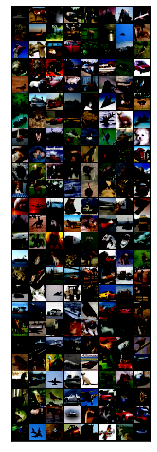

In [4]:
#Visualise the dataset

print(images.size())

def imshow(img):
  im = torchvision.utils.make_grid(img)
  npimg = im.cpu().numpy()
  print(npimg.shape)
  plt.figure(figsize=(8,8))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.xticks([])
  plt.yticks([])
  plt.show()

imshow(images)

In [0]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
#Defining generator

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator,self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0),
      nn.BatchNorm2d(ngf * 8),
      nn.ReLU(True),
      # state size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),
      # state size. (ngf*4) x 8 x 8
      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),
      # state size. (ngf*2) x 16 x 16
      nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),
      # state size. (ngf) x 32 x 32
      nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
      nn.Tanh()
    
  
    )
  def forward(self, input):
    return self.model(input)

In [7]:
G = Generator(ngpu).to(device)
G
G.apply(init_weights)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [0]:
#Defining Discriminator

class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(

    nn.Conv2d(nc, ndf, 4, 2, 1),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
    nn.BatchNorm2d(ndf * 2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
    nn.BatchNorm2d(ndf * 4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf * 8, 1, 4, 1, 0),
    nn.Sigmoid()   

    )

  def forward(self, input):
    return self.model(input)

In [9]:
D = Discriminator(ngpu).to(device)
D
D.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [0]:
#Setup for training loop

criterion = nn.BCELoss()

real_label = 1
fake_label = 0

G_loss_avg = 0.0
D_loss_avg = 0.0

fixed_noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)

G_optimiser = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))
D_optimiser = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0, D_Loss: 1.4111084938049316, G_Loss: 1.0947060585021973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


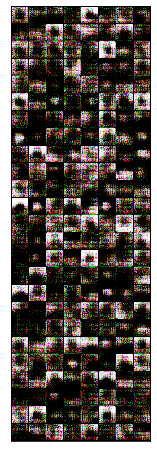

Epoch: 1, D_Loss: 1.260974407196045, G_Loss: 1.2470955848693848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


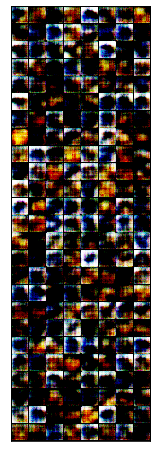

Epoch: 2, D_Loss: 1.2306911945343018, G_Loss: 2.022420883178711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


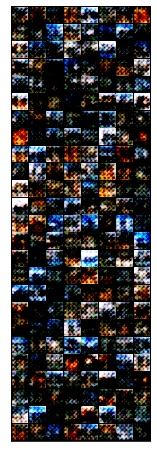

Epoch: 3, D_Loss: 0.36094772815704346, G_Loss: 2.9640209674835205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


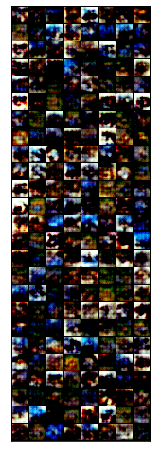

Epoch: 4, D_Loss: 1.3367187976837158, G_Loss: 0.9425293803215027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


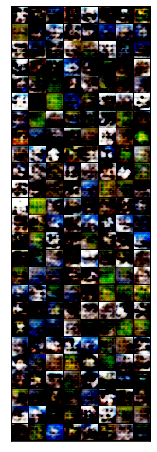

Epoch: 5, D_Loss: 1.2635371685028076, G_Loss: 2.7724826335906982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


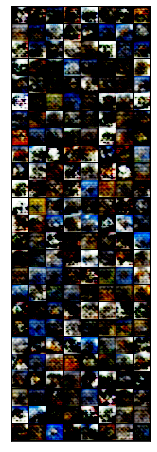

Epoch: 6, D_Loss: 0.8819897770881653, G_Loss: 1.4183517694473267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


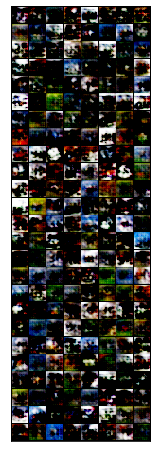

Epoch: 7, D_Loss: 1.1035196781158447, G_Loss: 1.094260811805725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


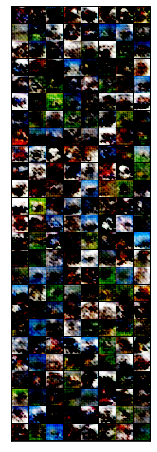

Epoch: 8, D_Loss: 0.6675410866737366, G_Loss: 1.7170660495758057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


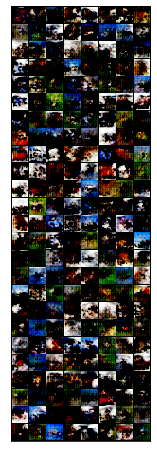

Epoch: 9, D_Loss: 1.1194074153900146, G_Loss: 1.3321880102157593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


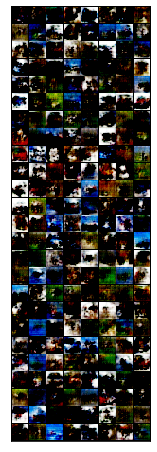

Epoch: 10, D_Loss: 1.1760023832321167, G_Loss: 1.4625588655471802


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


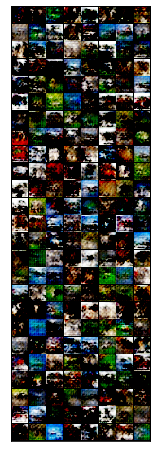

Epoch: 11, D_Loss: 0.9653702974319458, G_Loss: 1.169451117515564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


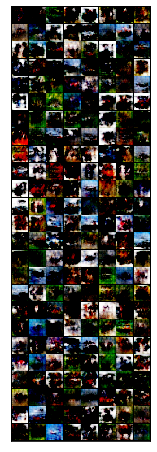

Epoch: 12, D_Loss: 1.020142912864685, G_Loss: 1.3643466234207153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


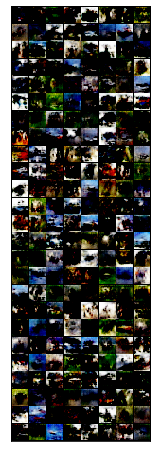

Epoch: 13, D_Loss: 1.3136838674545288, G_Loss: 1.6529403924942017


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


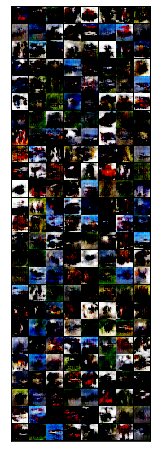

Epoch: 14, D_Loss: 0.7141774892807007, G_Loss: 3.1107547283172607


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


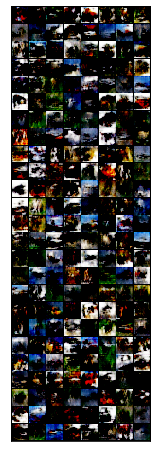

Epoch: 15, D_Loss: 0.6140207648277283, G_Loss: 2.7300217151641846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


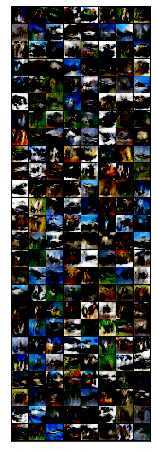

Epoch: 16, D_Loss: 0.9274786114692688, G_Loss: 3.095691442489624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


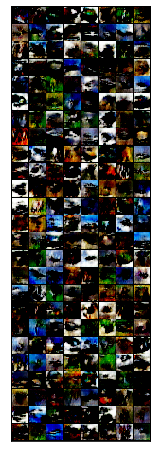

Epoch: 17, D_Loss: 2.383908987045288, G_Loss: 2.211404800415039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


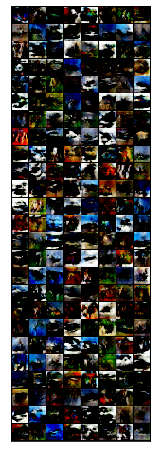

Epoch: 18, D_Loss: 1.2586283683776855, G_Loss: 0.9922844171524048


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


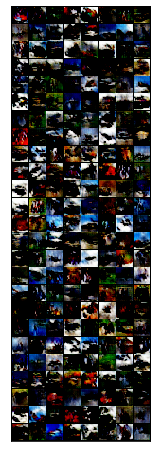

Epoch: 19, D_Loss: 1.3630291223526, G_Loss: 4.067203998565674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


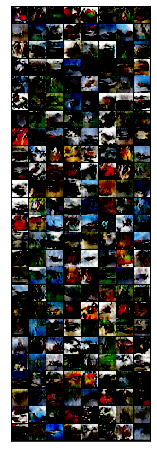

Epoch: 20, D_Loss: 0.14274394512176514, G_Loss: 3.3100366592407227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


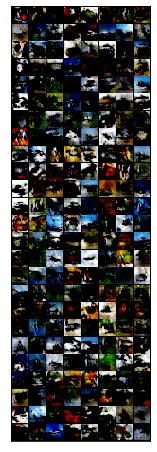

Epoch: 21, D_Loss: 0.3636261820793152, G_Loss: 2.9681365489959717


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


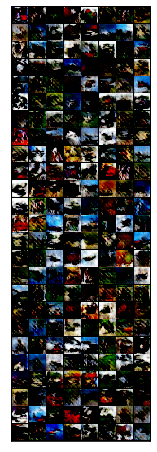

Epoch: 22, D_Loss: 1.040844440460205, G_Loss: 1.3716650009155273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


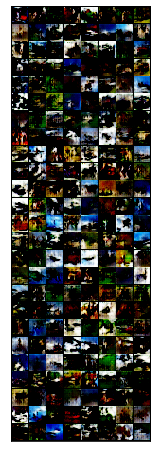

Epoch: 23, D_Loss: 0.4834669828414917, G_Loss: 4.803956985473633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


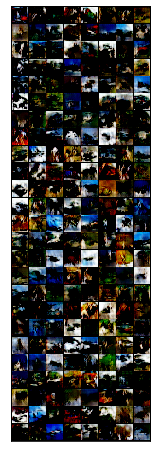

Epoch: 24, D_Loss: 0.3158167600631714, G_Loss: 2.568319797515869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


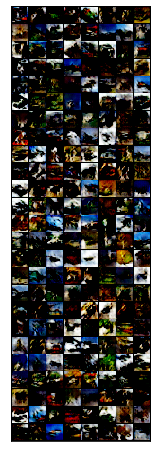

In [11]:
#Training loop

for epoch in range(EPOCHS):
  counter = 0
  for image_batch, _ in dataloader:
    label = torch.full((BATCH_SIZE,), real_label, device=device)
    
    D.zero_grad()

    output = D(image_batch.to(device))
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    #Train with fake
    noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
    fake = G(noise)
    label.fill_(fake_label)
    output = D(fake.detach())
    errD_fake = criterion(output, label)
    errD_fake.backward()

    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    D_optimiser.step()

    #Update G network

    G.zero_grad()
    label.fill_(real_label)
    output = D(fake)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    G_optimiser.step()

    counter += 1

    #print(epoch, counter, len(dataloader), errD.item(), errG.item())
          

  with torch.no_grad():
    print("Epoch: {}, D_Loss: {}, G_Loss: {}".format(epoch, errD.item(), errG.item()))
    samples = G(fixed_noise).detach()
    samples = samples.view(samples.size(0), nc, img_size, img_size)
    imshow(samples)
     
